<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">3D Regional Wave Propagation</div>
        </div>
    </div>
</div>

This tutorial is an extension of the global 3D one to show that everything works exactly the same in 3D, this time on an example that is a bit more realistic. Additionally it showcases the ObsPy integration a bit more.

We will simulate low-frequency wave originating from the March 6th Switzerland earthquake.

In [1]:
%matplotlib inline

import os
import warnings
warnings.simplefilter("ignore")

import salvus_seismo

# Paths are grabbed from environment variables.
PARAVIEW_BIN = os.environ["PARAVIEW_BIN"]
SALVUS_BIN = os.environ["SALVUS_BIN"]

## Get event and stations

Step 1 is to get the earthquake and the stations.

1 Event(s) in Catalog:
2017-03-06T20:12:06.790000Z | +46.916,   +8.931 | 4.4 ML | manual


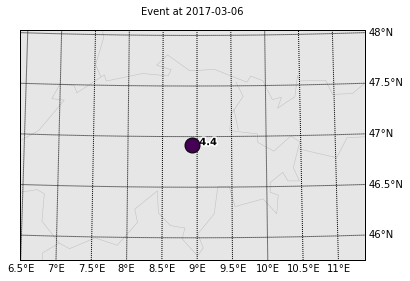

In [2]:
# For the event we will use the Italian event web service as they do have a
# moment tensor solution of the earthquake.
from obspy.clients.fdsn import Client
import obspy

# Initialize a client for the INGV webservice.
c = Client("INGV")

cat = c.get_events(starttime=obspy.UTCDateTime(2017, 3, 6), endtime=obspy.UTCDateTime(2017, 3, 7),
                   minmagnitude=4, maxmagnitude=5, latitude=47, longitude=8, maxradius=2)

print(cat)
cat.plot(projection="local")

event = cat[0]

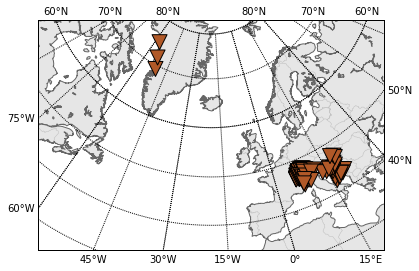

In [3]:
# For the stations we will use the swiss service and just get
# all stations available at the time of the event.
c = Client("ETH")
inv = c.get_stations(starttime=obspy.UTCDateTime(2017, 3, 6),
                     endtime=obspy.UTCDateTime(2017, 3, 7))
inv.plot(projection="local");

## Create a mesh

Next step is to create a mesh.

In this tutorial we'll run a sesimic simulation on a 3D regional Earth model. We'll also use the `salvus_seismo` subpackage to make adding source and receiers a breeze. Let's get a suitable mesh centered around Zurich.

In [4]:
# This nice little tool gets you the coordinates of a place of desire.
!python -m pymesher.getcoordinates zurich

best match:  Zürich, Bezirk Zürich, Zürich, Schweiz/Suisse/Svizzera/Svizra
input for pymesher SphericalChunk3D meshes with geocentric latitude
[47.180579, 8.542322, null]


In [5]:
!python -m pymesher.interface SphericalChunk3D \
    --basic.period=30 \
    --basic.model prem_iso_one_crust \
    --spherical.min_radius=6200 \
    --chunk3D.max_colatitude1=2.0 \
    --chunk3D.max_colatitude2=2.0 \
    --chunk3D.euler_angles 47.176739 8.540443 0 \
    --overwrite

Setting up background model and element sizes...
Creating the skeleton...
Creating the unstructured mesh...
attaching elastic parameters
attaching attenuation parameters
Computing mesh quality...
Writing mesh to file...
SUMMARY OF MESH PROPERTIES:

  model name                       | prem_iso_one_crust
  dominant period input            |     30.00 s
  elements per wavelength          |      2.00
  Courant Number                   |      0.60

  resolved period (global max)     |     27.80 s
    location (z coordinate)        |   6358.72 km
  resolved period (percentile 95)  |     27.80 s
  time step dt                     |    2.5241 s
    location (z coordinate)        |   6358.72 km
  number of elements               |       400
  number of points                 |       605
  cost factor (nelem / dt)         |  1.58e+02

  max edge aspect ratio            |      1.82
  max equiangular skewness         |      0.00
GLOBAL VARIABLES:
  dt                         |   2.52414
  ellipti

Now, let's visualize the mesh in Paraview and inspect it.

In [6]:
!$PARAVIEW_BIN ./SphericalChunk3D_prem_iso_one_crust_30.e

Below, we'll rely on `salvus_seismo` to generate a call to Salvus for us. This is a `python` package which makes it simple to generate sources and receivers for use in global 2D/3D Earth models. No more messing around on the command line line as before! Check out the comments below for an explanation of the individual parameters.

In [7]:
import salvus_seismo

src = salvus_seismo.Source.parse(event)
recs = salvus_seismo.Receiver.parse(inv)

# Choose a center frequency suitable for our mesh.
src.center_frequency = 1.0 / 33.0

# Generate the configuration object for salvus_seismo. Note the presence of "salvus_call"
# here. This can be use to pass any special commands, such as mpirun.
#
# This is a short simulation for speed reasons. Set the endtime to maybe 120 seconds
# if you have some time.
config = salvus_seismo.Config(
    mesh_file="./SphericalChunk3D_prem_iso_one_crust_30.e",
    end_time=30,
    salvus_call=SALVUS_BIN,
    movie_file_name="test_movie.h5",
    movie_fields=["u_ELASTIC"],
    polynomial_order=4,
    verbose=False,
    dimensions=3)

# Ensure a clean directory. Salvus_seismo will fail to produce the configuration files if
# the directory already exists.
!rm -rf 3d_example/

# Automatically generate the command line call for salvus. This takes the mesh file as an
# argument, as salvus_seismo will ensure that the source / receiver positions are adjusted
# to respect the mesh topology.
salvus_seismo.generate_cli_call(
    source=src, receivers=recs, config=config,
    output_folder="3d_example",
    exodus_file="./SphericalChunk3D_prem_iso_one_crust_30.e")

Retrieving surface information from exodus file ... [DONE in 0.03 seconds]
Automatically determined the following absorbing boundary side sets: p0, p1, r0, t0, t1
Could not locate station 8X.CA03A on mesh. Outside of mesh? latitude =  18.42, longitude =  43.68
Could not locate station 8X.CA06A on mesh. Outside of mesh? latitude =  16.25, longitude =  42.20
Could not locate station 8X.CA01A on mesh. Outside of mesh? latitude =  19.37, longitude =  43.43
Could not locate station 8X.CA07A on mesh. Outside of mesh? latitude =  16.06, longitude =  43.40
Could not locate station 8X.CA05A on mesh. Outside of mesh? latitude =  16.18, longitude =  42.86
Could not locate station 8X.CA02A on mesh. Outside of mesh? latitude =  18.59, longitude =  42.98
Could not locate station 8X.CA09A on mesh. Outside of mesh? latitude =  17.15, longitude =  42.79
Could not locate station 8X.CA08A on mesh. Outside of mesh? latitude =  17.36, longitude =  42.58
Could not locate station 8X.CA04A on mesh. Outside of

This call should generate a directory with some parameter files inside. All the receiver information is now contained within the file `receivers.toml`, and a snippet containing the command line parameters can be seen in `run_salvus.sh`. We'll take a look at them below.

In [8]:
!echo "\n\nreceivers.toml:\n"
!head -n 20 3d_example/receivers.toml

!echo "\n\nSalvus run command:\n"
!cat 3d_example/run_salvus.sh



receivers.toml:

[[receiver]]
network = "C4"
station = "CERN5"
location = ""
physical_latitude = 46.11764
physical_longitude = 6.07608
physical_depth_in_meters = 0.00000
medium = "solid"
salvus_coordinates = [4391392.73248, 467450.31225, 4591941.82537]
transform_matrix = [ [0.68929, 0.07337, 0.72076],
                     [-0.71672, -0.07629, 0.69318],
                     [-0.10585, 0.99438, 0.00000] ]

[[receiver]]
network = "C4"
station = "CERNS"
location = ""
physical_latitude = 46.07468
physical_longitude = 6.06621
physical_depth_in_meters = 0.00000


Salvus run command:

/home/boehm/SalvusInc/salvus_wave/build/salvus --dimension 3 --mesh-file ./SphericalChunk3D_prem_iso_one_crust_30.e --model-file ./SphericalChunk3D_prem_iso_one_crust_30.e --end-time 30.0 --polynomial-order 4 --receiver-file-name receiver.h5 --receiver-fields u_ELASTIC --absorbing-boundaries p0,p1,r0,t0,t1 --save-movie --movie-file-name test_movie.h5 --movie-fields u_ELASTIC --receiver-toml 3d_example/receivers

In [9]:
!sh ./3d_example/run_salvus.sh


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Start time set to -51.459989.
Time step set to: 0.281515 s.
Start time set to -51.459989.
Begin time loop.
Time loop progress [100%].
Time loop completed in 2.94579 seconds.
Begin post processing.
Problem complete.



When the simulation is done, we can go ahead and view the movie using the topology output by petsc.

In [10]:
!python ./petsc_gen_xdmf.py ./test_movie.h5

In [11]:
!$PARAVIEW_BIN ./test_movie.xmf

Feel free to load the data in the ASDF sextant to view it in a convenient way.